In [4]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from typing import List
from tqdm.notebook import tqdm

In [5]:
class Provider:

    def __init__(self, commission: float, conversion: float, processing_time: float):
        self.commission = commission
        self.conversion = conversion
        self.processing_time = processing_time

    def __repr__(self):
        return f"Коммисия: {self.commission}, Время обработки: {self.processing_time}, Конверсия: {self.conversion}"

In [6]:
providers: List[Provider] = []

for _, row in pd.read_csv("data/providers_1.csv").drop_duplicates(subset=["ID"]).iterrows():
    providers.append(
        Provider(
            commission=row["COMMISSION"],
            conversion=row["CONVERSION"],
            processing_time=row["AVG_TIME"]
        )
    )

for _, row in pd.read_csv("data/providers_2.csv").drop_duplicates(subset=["ID"]).iterrows():
    providers.append(
        Provider(
            commission=row["COMMISSION"],
            conversion=row["CONVERSION"],
            processing_time=row["AVG_TIME"]
        )
    )

In [7]:
def compute_expected_processing_time(chain: List[Provider]) -> float:
    probas, values = [], []

    for k in range(len(chain)):
        multiplication = np.prod([1 - provider.conversion for provider in chain[:k]])

        probas.append(multiplication * chain[k].conversion)

        values.append(np.sum([provider.processing_time for provider in chain[:k + 1]]))

    probas, values = np.array(probas), np.array(values)

    return probas.dot(values)


def compute_expected_conversion(chain: List[Provider]) -> float:
    return 1 - np.prod([1 - provider.conversion for provider in chain])


def compute_expected_commission(chain: List[Provider]) -> float:
    probas, values = [], []

    for k in range(len(chain)):
        multiplication = np.prod([1 - provider.conversion for provider in chain[:k]])

        probas.append(multiplication * chain[k].conversion)
        values.append(chain[k].commission)

    probas, values = np.array(probas), np.array(values)

    return probas.dot(values)

In [8]:
CHAIN_LENGTHS = range(2, len(providers))
N_EXPS = 1000
SEED = 42

#random.seed(SEED)

average_expected_processing_time = []
average_expected_commission = []
average_expected_conversion = []

for chain_length in tqdm(CHAIN_LENGTHS):
    expected_processing_times = []
    expected_commissions = []
    expected_conversions = []
    
    for _ in range(N_EXPS):
        chain = random.sample(population=providers, k=chain_length)
        #chain = sorted(chain, key=lambda p: p.conversion, reverse=True)

        expected_processing_times.append(compute_expected_processing_time(chain))
        expected_commissions.append(compute_expected_commission(chain))
        expected_conversions.append(compute_expected_conversion(chain))

    average_expected_processing_time.append(np.mean(expected_processing_times))
    average_expected_commission.append(np.mean(expected_commissions))
    average_expected_conversion.append(np.mean(expected_conversions))

  0%|          | 0/87 [00:00<?, ?it/s]

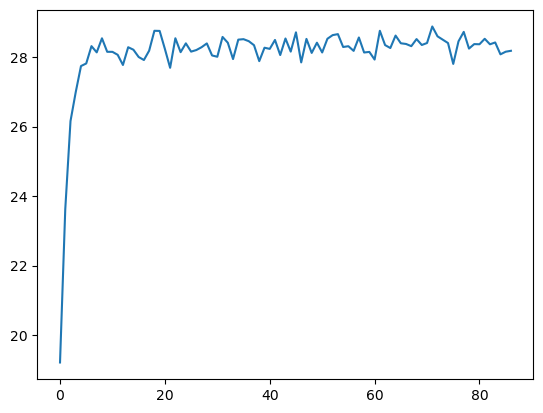

In [9]:
plt.plot(average_expected_processing_time)